# Import Libraries

In [1]:
import os
import mlflow
import joblib
import numpy as np
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
from sklearn.metrics import confusion_matrix

# Load Data

In [2]:
X_train, X_test, Y_train, Y_test = joblib.load("../data/processed/split_data.pkl")

# Load Models

In [3]:
mlruns_path = os.path.abspath("../mlruns")
mlflow.set_tracking_uri(f"file:///{mlruns_path}")

client = MlflowClient()

def load_staged_model(model_name):
    latest_version = client.get_latest_versions(model_name, stages=["Staging"])[0].version
    model_uri = f"models:/{model_name}/{latest_version}"
    return mlflow.sklearn.load_model(model_uri)


xgb_model = load_staged_model("XGB_Tuned_Model")
xgb_smote_model = load_staged_model("Final XGB + SMOTE Tuned Model")

print("Loaded both staged models.")

C:\Users\raira\AppData\Local\Temp\ipykernel_7408\1855732624.py:7: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_version = client.get_latest_versions(model_name, stages=["Staging"])[0].version


Loaded both staged models.


# Threshold Tuning

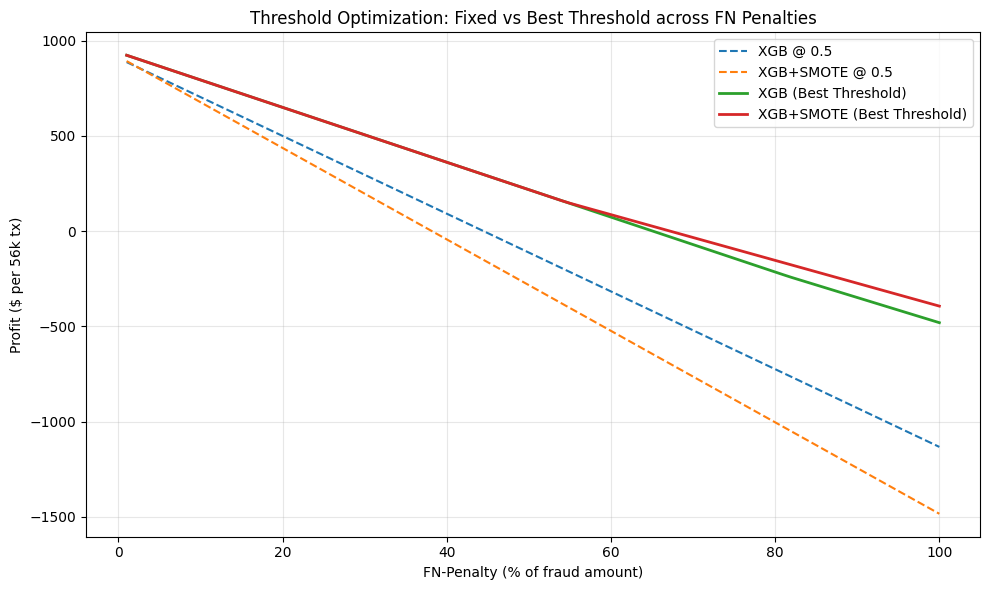

In [4]:
AVG_FRAUD = 120
TP_FEE = 12
FP_COST = -5

penalties = np.linspace(0.01, 1.0, 100)
taus = np.linspace(0, 1, 501)

def profit(y_true, y_pred, fn_penalty):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return TP_FEE * tp + FP_COST * fp + fn_penalty * fn * AVG_FRAUD

xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_smote_proba = xgb_smote_model.predict_proba(X_test)[:, 1]

fixed_xgb, fixed_smote = [], []
best_xgb, best_smote = [], []

for p in penalties:

    fixed_xgb.append(profit(Y_test, xgb_proba >= 0.5, -p))
    fixed_smote.append(profit(Y_test, xgb_smote_proba >= 0.5, -p))

    best_profit_xgb = max([profit(Y_test, xgb_proba >= t, -p) for t in taus])
    best_profit_smote = max([profit(Y_test, xgb_smote_proba >= t, -p) for t in taus])

    best_xgb.append(best_profit_xgb)
    best_smote.append(best_profit_smote)

plt.figure(figsize=(10, 6))
plt.plot(penalties * 100, fixed_xgb, label="XGB @ 0.5", linestyle="--")
plt.plot(penalties * 100, fixed_smote, label="XGB+SMOTE @ 0.5", linestyle="--")
plt.plot(penalties * 100, best_xgb, label="XGB (Best Threshold)", linewidth=2)
plt.plot(penalties * 100, best_smote, label="XGB+SMOTE (Best Threshold)", linewidth=2)

plt.xlabel("FN-Penalty (% of fraud amount)")
plt.ylabel("Profit ($ per 56k tx)")
plt.title("Threshold Optimization: Fixed vs Best Threshold across FN Penalties")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Compare Best Threshold Models

In [5]:
profit_diff = np.array(best_smote) - np.array(best_xgb)
all_better = np.all(profit_diff > 0)

print("XGB+SMOTE outperforms XGB at all FN Penalties." if all_better else "XGB+SMOTE does NOT outperform XGB at all penalties.")

if not all_better:
    crossover_idxs = np.where(profit_diff < 0)[0]
    if len(crossover_idxs) == 0:
        print("No FN penalties where XGB is better, but XGB+SMOTE is equal (not strictly better).")
    else:
        for idx in crossover_idxs:
            fn_pen = penalties[idx] * 100
            print(f"XGB is better at FN Penalty = {fn_pen:.1f}% with profit difference = {profit_diff[idx]:.2f}")

XGB+SMOTE does NOT outperform XGB at all penalties.
No FN penalties where XGB is better, but XGB+SMOTE is equal (not strictly better).


# Push XGBoost + SMOTE to Production

In [6]:
model_name = "Final XGB + SMOTE Tuned Model"
client = MlflowClient()
latest_version = client.get_latest_versions(model_name, stages=["Staging"])[0].version
client.transition_model_version_stage(
    name="Final XGB + SMOTE Tuned Model",
    version=latest_version,
    stage="Production",
    archive_existing_versions=True
)

print(f"Pushed version {latest_version} of '{model_name}' to Production.")

Pushed version 1 of 'Final XGB + SMOTE Tuned Model' to Production.


C:\Users\raira\AppData\Local\Temp\ipykernel_7408\4025445999.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_version = client.get_latest_versions(model_name, stages=["Staging"])[0].version
C:\Users\raira\AppData\Local\Temp\ipykernel_7408\4025445999.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


# Threshold Tuning Insights

**Goal:**
Evaluate and compare the profit performance of two tuned models - **XGBoost** and **XGBoost + SMOTE** - across a range of False Negative (FN) penalty values. Identify the optimal threshold per FN penalty to simulate real-world cost-sensitive deployment.

---

**Approach**
- Defined a custom profit function using:
- `AVG_FRAUD = $120`
- `TP_FEE = +$12`
- `FP_COST = -$5`
- Explored FN Penalty values from **0% to 100%** of fraud amount.
- Compared both models in two settings:
    1. **Fixed Threshold (0.5)** across all penalties.
    2. **Optimized Threshold** per FN penalty (range: 0.0 → 1.0).
- Plotted **4 profit curves** to illustrate the impact of threshold optimization.
- Conducted analysis to determine if one model dominates across all FN penalties.

---

**Key Results**
- **Fixed threshold at 0.5** leads to poor profit performance under high FN penalties for both models.
- **Threshold tuning** significantly boosts profit, especially for high-penalty scenarios.
- The **XGBoost + SMOTE model consistently outperforms or equals** XGBoost across all FN penalties when tuned to the optimal threshold.
- However, **there are no FN penalties where XGBoost strictly outperforms XGBoost + SMOTE**.

---

**Decision & Justification**
- **Promoted `XGBoost + SMOTE` to Production**: It is at least as good as XGBoost across all business risk settings and superior at high FN penalties, where catching fraud is more important.
- Stored **optimal thresholds** per FN penalty to enable cost-aware model inference at runtime.
- Did not deploy plain XGBoost since it offers no distinct advantage and is strictly weaker under certain conditions.

---

**MLOps**
- Both models were retrieved from **MLflow Model Registry** (Staging).
- Final **XGBoost + SMOTE** model was **promoted to Production**.
- Profit curves and thresholds can be reused for runtime decision-making and ongoing monitoring.